## Stock Price Prediction using Time Series Analysis

##### In this notebook, we aim to make predictions of stock prices, which will help investors gain more insight on the movement of the stock market and make profitable investments. We will be using the New York Stock Exchange dataset from Kaggle, provided by Dominik Gawlik. 

##### The data consist of four csv files, where the fundamental data and historical prices of S&P 500 companies are presented. We will only be using the prices data. Prices were fetched from Yahoo Finance, fundamentals are from Nasdaq Financials, extended by some fields from EDGAR SEC databases. 

##### We plan to use the technique of Machine learning to make the predictions. After splitting the data into train and test sets, we will use and neural networks to predict, and evaluate the performance by calculating net profit generated by our prediction or counting the frequency of large errors. We would also like to compare the performance of different models and find out the most accurate prediction. 


##### We start by taking a deeper look at our data, redesign the data into a usable and functional format and correct/remove any bad data. Note that we have two price dataset, 'prices.csv' and 'prices-split-adjusted.csv'. They are basically the same, but there have been added adjustments for 'prices-split-adjusted.csv'. We will be using 'prices-split-adjusted.csv' dataset.

In [ ]:
# import the modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARMA
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# load the price 
adjusted_price = pd.read_csv('/work/prices-split-adjusted.csv')

In [ ]:
# looking into the dataset
adjusted_price.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
adjusted_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [ ]:
adjusted_price.shape

(851264, 7)

In [ ]:
# check if there are missing values in adjusted_price
missing1 = pd.concat([adjusted_price.isnull().sum(), 100 * adjusted_price.isnull().mean()], axis=1)
missing1.columns=['count', '%']
missing1.sort_values(by='count', ascending=False)

,count,%
date,0,0.0
symbol,0,0.0
open,0,0.0
close,0,0.0
low,0,0.0
high,0,0.0
volume,0,0.0


##### From the prelimary investigation of our data, we see that there are 851264 rows and 7 columns in the data, where each row represent the (open, close, high, low) stock prices and volume of one stock in one day (between 2010 and 2016.) There are no missing values so we do not need to do any fill or delete any roes at this stage. We do not need all the columns for the purpose of this project, we will use open prices to make the prediction.

##### Since all the stocks are stored together in one dataset, we will further investigate by grouping the prices on one stock together. 

In [ ]:
# find out how many stocks there are...
stocks = adjusted_price['symbol'].unique().tolist()
len(stocks)

501

In [ ]:
# find out how many dates of prices are recorded for each stock
adjusted_price['symbol'].value_counts()

HRS     1762
AEP     1762
PH      1762
MUR     1762
RF      1762
        ... 
PYPL     378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

##### There are 501 stocks in the dataset with diffferent number of dates that are recorded.

<AxesSubplot:xlabel='date'>

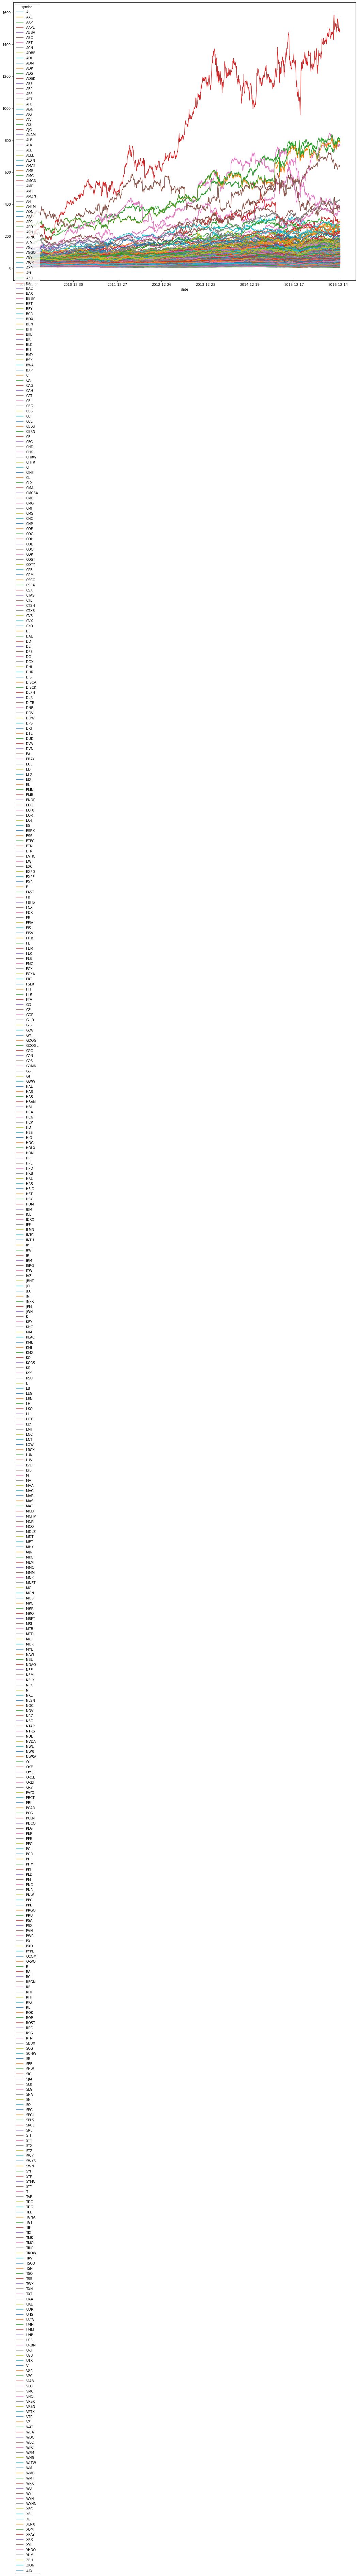

In [ ]:
plt.rcParams["figure.figsize"] = (18, 15)
adjusted_price.groupby(['date', 'symbol'])['open'].sum().unstack().plot(legend=False) 

#### Evaluation

##### In this project, we will use Mean Squared Error and Mean Absolute Percentage Error to evaluate the performance of each model

In [ ]:
def mse(a, b):

    summation = 0  #variable to store the summation of differences
    n = len(a) #finding total number of items in list

    for i in range (0,n):  #looping through each element of the list
        difference = a[i] - b[i]  #finding the difference between observed and predicted value
        squared_difference = difference**2  #taking square of the differene 
        summation = summation + squared_difference  #taking a sum of all the differences

    MSE = summation/n  #dividing summation by total values to obtain average

    return MSE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### A Simple Model

##### First, we would like construct a very simple model, predict the stock prices using their average prices, as comparison to other models. In this model, we will split the data of each stock into test and train set(70% train, 30% test,) and use the average price of the train set as out result and compare it to the real data to see the performance.

In [ ]:
# construct an empty dataframe to store the scores 

column_names = ["stock name", "model_1 mse", "model_1 mape"]

evaluation = pd.DataFrame(columns = column_names)

# loop through every stock, split the data for each stock, find the mean, and compare reuslts 
for stock in stocks:

    #store the open prices for the current stock as temp
    temp = adjusted_price[adjusted_price['symbol'] == stock]['open'].tolist()

    #the number of datapoints we have of the current stock 
    n = len(temp)

    # split test, train set 
    train_size = int(n * 0.7)
    test_size = n - train_size

    train_X = temp[ : train_size] 
    true_y = temp[train_size : n]

    #calculate the mean of the train set
    average = sum(train_X) / train_size

    #define pred_y as a list of average price with length of the test size 
    pred_y = [average] * test_size

    #evalute performance 
    temp_mse = mse(true_y, pred_y)
    temp_mape = mean_absolute_percentage_error(true_y, pred_y)

    # store the result in the dataframe evaluation
    evaluation = evaluation.append({'stock name': stock, 'model_1 mse': temp_mse, 'model_1 mape': temp_mape}, ignore_index=True)


<AxesSubplot:>

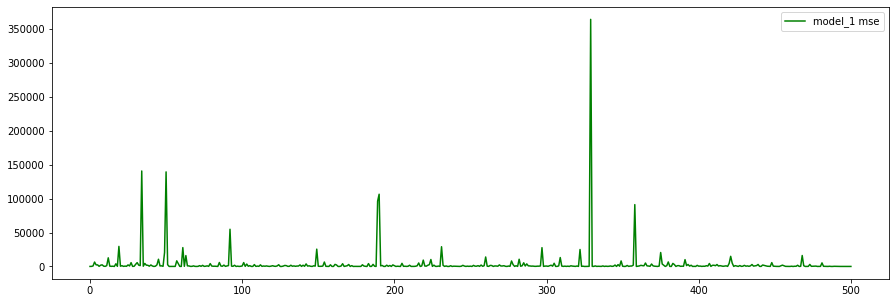

In [ ]:
evaluation[['model_1 mse']].plot(figsize = (15,5), color=['green'])

<AxesSubplot:>

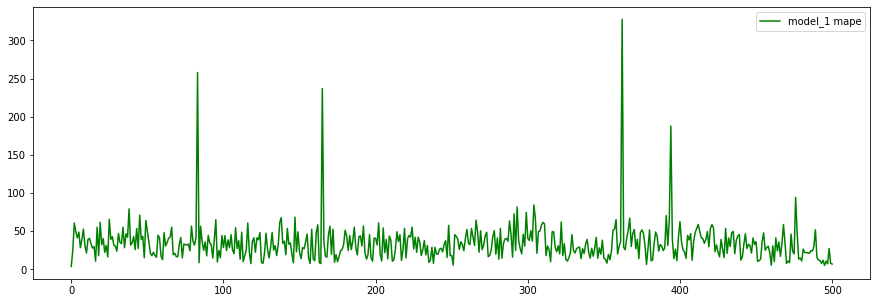

In [ ]:
evaluation[['model_1 mape']].plot(figsize = (15,5), color=['green'])

##### From the plots, we can see that using average provide relatively good results for some stocks (near to 0 mse and mape.) However, for other stocks, this method is provide horriable result with extremely high mse and mape. In general, this simple model is not accurate.

## Time Series Analysis

### ARMA Model

In [ ]:
# add empy column to store the scores for arma model
evaluation['model_2 mse'] = ''
evaluation['model_2 mape'] = ''

In [ ]:
# intialize a dict to store the best parameter to use for each stock data
best_para_dict = {}

#loop through the stocks 
for stock in stocks:

    #store the open prices for the current stock as temp
    temp = adjusted_price[adjusted_price['symbol'] == stock]['open']

    #the number of datapoints we have of the current stock 
    n = temp.shape[0]

    # define X
    temp_price = temp.squeeze()

    # split test, train set 
    train_size = int(n * 0.7)
    test_size = n - train_size

    train_X = temp_price.iloc[ : train_size] 
    true_y = temp_price.iloc[train_size : n]

    mse_dic = {}

    for i in range(0,5):
        for j in range(0,5):
                try:
                    mod = ARMA(train_X, order=(i,j))
                    res = mod.fit()
                    result_ = res.predict(start = train_size , end = n)
                    mse_v = mse(true_y.tolist(), result_.tolist())
                    mse_dic[(i,j)] = mse_v
                except:
                    pass

    best_para = min(mse_dic, key=mse_dic.get)
    best_para_dict[stock] = best_para

statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning

In [ ]:
# turn the dict into a dataframe
df = pd.DataFrame.from_dict(best_para_dict, orient='index')

,0,1
WLTW,1,4
A,3,2
AAL,3,0
AAP,2,0
AAPL,2,4
...,...,...
KHC,3,4
PYPL,2,4
HPE,4,4
CSRA,1,4


In [ ]:
# write the dataframe into a csv file
df.to_csv('best_param_arma.csv')

In [ ]:
aram_param = pd.read_csv('best_param_arma.csv')

In [ ]:
aram_param

,Unnamed: 0,0,1
0,WLTW,1,4
1,A,3,2
2,AAL,3,0
3,AAP,2,0
4,AAPL,2,4
...,...,...,...
496,KHC,3,4
497,PYPL,2,4
498,HPE,4,4
499,CSRA,1,4


In [ ]:
aram_dict = aram_param.set_index('Unnamed: 0').T.to_dict('list')

In [ ]:
aram_dict['WLTW'][0]

1

In [ ]:
stocks[0]

'WLTW'

In [ ]:
#
for stock in stocks:

    #store the open prices for the current stock as temp
    temp = adjusted_price[adjusted_price['symbol'] == stock]['open']

    #the number of datapoints we have of the current stock 
    n = temp.shape[0]

    # define X
    temp_price = temp.squeeze()

    # split test, train set 
    train_size = int(n * 0.7)
    test_size = n - train_size

    train_X = temp_price.iloc[ : train_size] 
    true_y = temp_price.iloc[train_size : n]
    print(len(true_y))

    best_para_1 = aram_dict[stock][0]
    best_para_2 = aram_dict[stock][1]

    best_mod = ARMA(train_X, order=(best_para_1, best_para_2))
    best_res = best_mod.fit()
    best_result = best_res.predict(start = train_size, end = (n-1)).tolist()
    print(len(best_result))

    
    #evaluation 
    best_mse = mse(true_y.tolist(), best_result)
    best_mape = mean_absolute_percentage_error(true_y.tolist(), best_result)

    # store the result in the dataframe evaluation
    evaluation.loc[evaluation['stock name'] == stock, 'model_2 mse'] = best_mse
    evaluation.loc[evaluation['stock name'] == stock, 'model_2 mape'] = best_mape


statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
At iterate   40    f=  1.23710D+00    |proj g|=  1.29287D-02

At iterate   45    f=  1.23664D+00    |proj g|=  5.99305D-03

At iterate   50    f=  1.23638D+00    |proj g|=  9.22231D-03

At iterate   55    f=  1.23637D+00    |proj g|=  5.49338D-03

At iterate   60    f=  1.23634D+00    |p

In [ ]:
evaluation

,stock name,model_1 mse,model_1 mape,model_2 mse,model_2 mape
0,WLTW,34.595567,3.968613,20.154099,2.970128
1,A,123.939860,24.929779,34.208769,9.853998
2,AAL,710.764122,60.913196,28.452734,10.165139
3,AAP,6485.721583,49.571213,545.785806,11.55321
4,AAPL,2333.709795,41.377065,88.199996,7.075912
...,...,...,...,...,...
496,KHC,101.235313,11.069442,8.68363,2.511958
497,PYPL,11.095613,7.375311,8.515572,6.114136
498,HPE,39.914360,27.474139,1.237522,3.911944
499,CSRA,12.583818,8.022185,11.165627,7.784836


<AxesSubplot:>

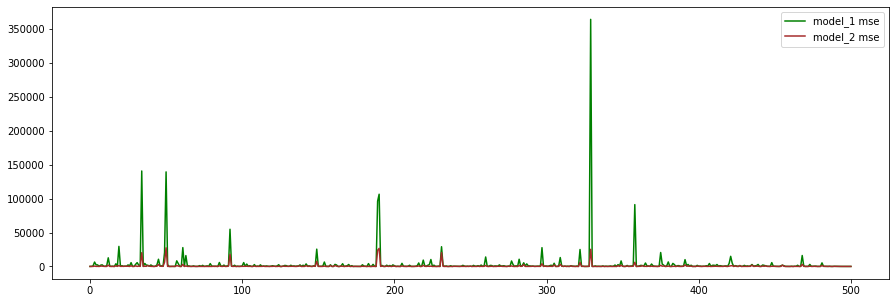

In [ ]:
evaluation[['model_1 mse', 'model_2 mse']].plot(figsize = (15,5), color=['green', 'brown'])

<AxesSubplot:>

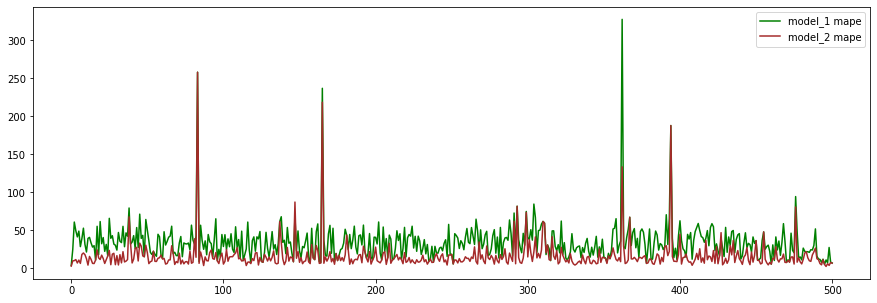

In [ ]:
evaluation[['model_1 mape', 'model_2 mape']].plot(figsize = (15,5), color=['green', 'brown'])

##### From the plots, we can see the ARMA model has largely improved the accuracy of stock predictions (the red line in both the graphs yeilds a lower MSE and MAPE score.) 

## LSTM for Regression

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
# add empy column to store the scores for arma model
evaluation['model_3 mse'] = ''
evaluation['model_3 mape'] = ''

In [1]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [2]:
for stock in stocks:

    temp = pd.DataFrame(adjusted_price[adjusted_price['symbol'] == stock]['open'])
    dataset = temp.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    #evaluation 
    best_mse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    best_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])

    # store the result in the dataframe evaluation
    evaluation.loc[evaluation['stock name'] == stock, 'model_3 mse'] = best_mse
    evaluation.loc[evaluation['stock name'] == stock, 'model_3 mape'] = best_mape

NameError: name 'stocks' is not defined

In [ ]:
evaluation.to_csv('evaluation.csv')

In [ ]:
evalu = pd.read_csv('evaluation.csv')

<AxesSubplot:>

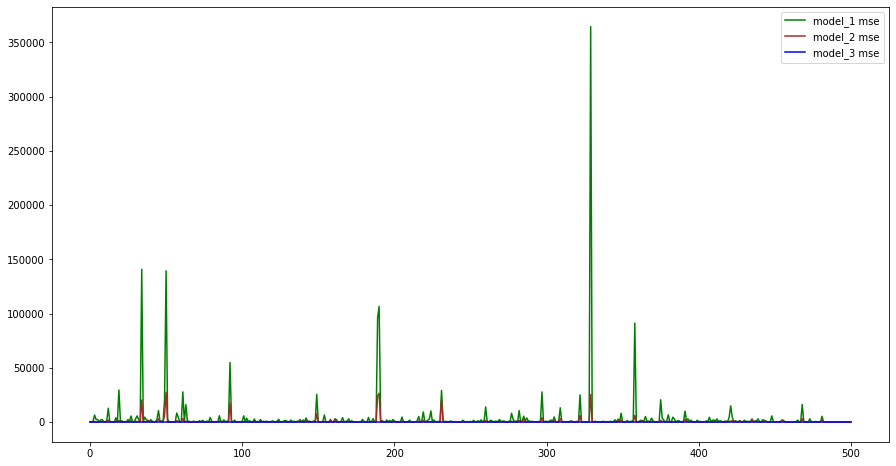

In [ ]:
evalu[['model_1 mse', 'model_2 mse', 'model_3 mse']].plot(figsize = (15,8), color=['green', 'brown', 'blue'])

<AxesSubplot:>

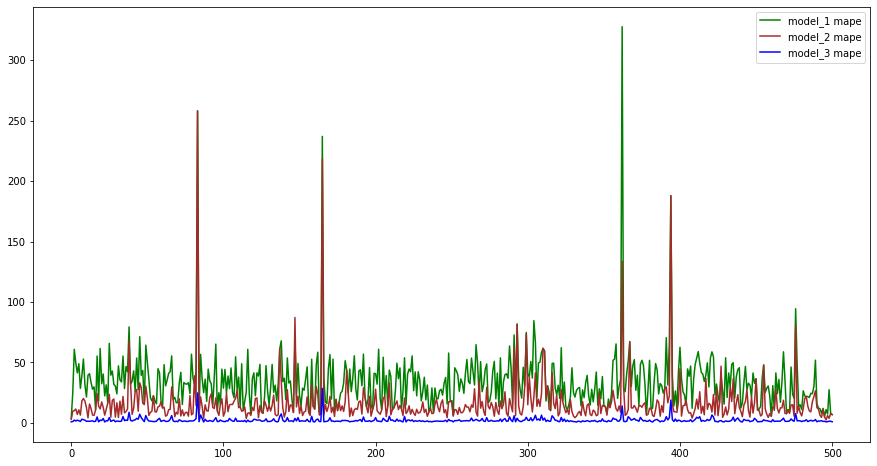

In [ ]:
evalu[['model_1 mape', 'model_2 mape', 'model_3 mape']].plot(figsize = (15,8), color=['green', 'brown', 'blue'])

In [ ]:
predicted_price = pd.DataFrame(columns = ['stock name', 'predicted price'])

In [ ]:
for i in range(len(stocks)):

    temp = pd.DataFrame(adjusted_price[adjusted_price['symbol'] == stocks[i]]['open'])
    mean = sum(temp['open'].tolist())/len(temp['open'].tolist())
    temp.loc[len(temp)] = mean
    temp.loc[len(temp)] = mean
    temp.loc[len(temp)] = mean
    temp.loc[len(temp)] = mean

    dataset = temp.values
    dataset = dataset.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset)-4)
    pred_size = 4
    train, pred = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    predX, predY = create_dataset(pred, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    predX = np.reshape(predX, (predX.shape[0], 1, predX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    # make predictions
    trainPredict = model.predict(trainX)
    predPredict = model.predict(predX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    predPredict = scaler.inverse_transform(predPredict)
    predY = scaler.inverse_transform([predY])

    # store the result in the dataframe evaluation
    predicted_price = predicted_price.append({'stock name' : stocks[i], 'predicted price' : predPredict[1,0]}, ignore_index = True)

Epoch 50/100
1760/1760 - 2s - loss: 1.8933e-04
Epoch 51/100
1760/1760 - 2s - loss: 1.8640e-04
Epoch 52/100
1760/1760 - 2s - loss: 1.8812e-04
Epoch 53/100
1760/1760 - 2s - loss: 1.8537e-04
Epoch 54/100
1760/1760 - 2s - loss: 1.8630e-04
Epoch 55/100
1760/1760 - 2s - loss: 1.9097e-04
Epoch 56/100
1760/1760 - 2s - loss: 1.8467e-04
Epoch 57/100
1760/1760 - 2s - loss: 1.9400e-04
Epoch 58/100
1760/1760 - 2s - loss: 1.8644e-04
Epoch 59/100
1760/1760 - 2s - loss: 1.8478e-04
Epoch 60/100
1760/1760 - 2s - loss: 1.8515e-04
Epoch 61/100
1760/1760 - 2s - loss: 1.8404e-04
Epoch 62/100
1760/1760 - 2s - loss: 1.8664e-04
Epoch 63/100
1760/1760 - 2s - loss: 1.8809e-04
Epoch 64/100
1760/1760 - 2s - loss: 1.8780e-04
Epoch 65/100
1760/1760 - 2s - loss: 1.8065e-04
Epoch 66/100
1760/1760 - 2s - loss: 1.8854e-04
Epoch 67/100
1760/1760 - 2s - loss: 1.8383e-04
Epoch 68/100
1760/1760 - 2s - loss: 1.8816e-04
Epoch 69/100
1760/1760 - 2s - loss: 1.8711e-04
Epoch 70/100
1760/1760 - 2s - loss: 1.8883e-04
Epoch 71/100


1760/1760 - 2s - loss: 3.4331e-04
Epoch 67/100
1760/1760 - 2s - loss: 3.4279e-04
Epoch 68/100
1760/1760 - 2s - loss: 3.3391e-04
Epoch 69/100
1760/1760 - 2s - loss: 3.4489e-04
Epoch 70/100
1760/1760 - 2s - loss: 3.3683e-04
Epoch 71/100
1760/1760 - 2s - loss: 3.4164e-04
Epoch 72/100
1760/1760 - 2s - loss: 3.3859e-04
Epoch 73/100
1760/1760 - 2s - loss: 3.4650e-04
Epoch 74/100
1760/1760 - 2s - loss: 3.4121e-04
Epoch 75/100
1760/1760 - 2s - loss: 3.3917e-04
Epoch 76/100
1760/1760 - 2s - loss: 3.4273e-04
Epoch 77/100
1760/1760 - 2s - loss: 3.3903e-04
Epoch 78/100
1760/1760 - 2s - loss: 3.3966e-04
Epoch 79/100
1760/1760 - 2s - loss: 3.4046e-04
Epoch 80/100
1760/1760 - 2s - loss: 3.3866e-04
Epoch 81/100
1760/1760 - 2s - loss: 3.3448e-04
Epoch 82/100
1760/1760 - 2s - loss: 3.4342e-04
Epoch 83/100
1760/1760 - 2s - loss: 3.4727e-04
Epoch 84/100
1760/1760 - 2s - loss: 3.4417e-04
Epoch 85/100
1760/1760 - 2s - loss: 3.3826e-04
Epoch 86/100
1760/1760 - 2s - loss: 3.4011e-04
Epoch 87/100
1760/1760 - 2

376/376 - 2s - loss: 0.1511
Epoch 2/100
376/376 - 0s - loss: 0.0390
Epoch 3/100
376/376 - 0s - loss: 0.0218
Epoch 4/100
376/376 - 0s - loss: 0.0101
Epoch 5/100
376/376 - 0s - loss: 0.0049
Epoch 6/100
376/376 - 0s - loss: 0.0034
Epoch 7/100
376/376 - 0s - loss: 0.0032
Epoch 8/100
376/376 - 0s - loss: 0.0032
Epoch 9/100
376/376 - 0s - loss: 0.0032
Epoch 10/100
376/376 - 0s - loss: 0.0032
Epoch 11/100
376/376 - 0s - loss: 0.0032
Epoch 12/100
376/376 - 0s - loss: 0.0032
Epoch 13/100
376/376 - 0s - loss: 0.0032
Epoch 14/100
376/376 - 0s - loss: 0.0033
Epoch 15/100
376/376 - 0s - loss: 0.0032
Epoch 16/100
376/376 - 0s - loss: 0.0033
Epoch 17/100
376/376 - 0s - loss: 0.0031
Epoch 18/100
376/376 - 0s - loss: 0.0032
Epoch 19/100
376/376 - 0s - loss: 0.0032
Epoch 20/100
376/376 - 0s - loss: 0.0032
Epoch 21/100
376/376 - 0s - loss: 0.0033
Epoch 22/100
376/376 - 0s - loss: 0.0032
Epoch 23/100
376/376 - 0s - loss: 0.0032
Epoch 24/100
376/376 - 0s - loss: 0.0032
Epoch 25/100
376/376 - 0s - loss: 0.0

In [ ]:
predicted_price.to_csv('predicted_price.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb4937d9-4ef1-4542-bee6-529d5ac2a998' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>